# Mod. Image Loader with Albumentation

Description: This notebook loads images from a directory, and handles imbalanced classes with down/re/upsampling and augmentation.

This notebook should be run from the top to the bottom, resulting in 3 files:

* `train_from_Metadata_processed.csv` - a csv file with the training data
* `validation_from_Metadata_processed.csv` - a csv file with the validation data
* `test_from_Metadata_processed.csv` - a csv file with the test data

These files encode the images with labels.


## Imports and inital setup

In [13]:
# Imports
import pandas as pd

from albumentations import (Compose, RandomCrop, Normalize, HorizontalFlip, Resize, RandomBrightnessContrast, CoarseDropout, GridDistortion, HueSaturationValue, GaussianBlur, Rotate, RandomResizedCrop)
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import os
import random
import sys

sys.path.append("..")
from helperfunctions import imagehelper as ih

SEED = 4932

MAX_SAMPLES_TRAIN = 750
MAX_SAMPLES_VAL = int(MAX_SAMPLES_TRAIN * 0.33)

# File path variables
# please make sure to use the correct path to the meta data file
FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_METADATA="./../data/processed/Metadata_processed.csv"
FILEPATH_OUTPUT = './../data/jpgs/' 

TARGET_LABEL="dx_binary"    # Needed for test train split
BALANCE_LABEL="dx"          # Needed for balancing the dataset
IMAGE_SIZE = (224, 224)     # Adapt to your model!

### Deleting all previously augmented images in advance

In [14]:
# Define the bash script as a string
bash_script = """
#!/bin/bash

output_folder="./../data/jpgs/" 

# Delete images with the "aug_" prefix
find "$output_folder" -type f -name "aug_*" -delete

echo "Deleted augmented images with 'aug_' prefix in $output_folder"
"""

# Save the bash script to a file
with open('delete_augmented_images.sh', 'w') as script_file:
    script_file.write(bash_script)

# Make the script executable
!chmod +x delete_augmented_images.sh

# Execute the script
!./delete_augmented_images.sh

# Delete the script
!rm delete_augmented_images.sh

Deleted augmented images with 'aug_' prefix in ./../data/jpgs/


### Loading the metadata file

In [15]:
# Read the metadata file
metadata = pd.read_csv(FILEPATH_METADATA)

# Concatenate the base directory with the image filename to add the full path
metadata['image_path'] = FILEPATH_JPGS + metadata['image_id']

metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,dx_binary,image_path
0,HAM_0000118,ISIC_0027419.jpg,bkl,histo,80.0,male,scalp,vidir_modern,not_skin_cancer,./../data/jpgs/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030.jpg,bkl,histo,80.0,male,scalp,vidir_modern,not_skin_cancer,./../data/jpgs/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769.jpg,bkl,histo,80.0,male,scalp,vidir_modern,not_skin_cancer,./../data/jpgs/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661.jpg,bkl,histo,80.0,male,scalp,vidir_modern,not_skin_cancer,./../data/jpgs/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633.jpg,bkl,histo,75.0,male,ear,vidir_modern,not_skin_cancer,./../data/jpgs/ISIC_0031633.jpg


# Splitting the data in train, validation and test sets

In [16]:
# Splitting the data into train, validation and test using train_test_split

# Split the data into two subsets: train and temp (60% train, 40% temp)
train_df, temp_df = train_test_split(metadata, test_size=0.4, stratify=metadata[TARGET_LABEL], random_state=SEED)

# Split the temp data into validation and test sets (50% each)
validation_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df[TARGET_LABEL], random_state=SEED)

# resetting the index
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

display(
    train_df.shape,
    validation_df.shape,
    test_df.shape
)

(6009, 10)

(2003, 10)

(2003, 10)

In [17]:
# Showing the number of samples per BALANCE_LABEL in train, validation and test set
print("Samples per class in train set:")
print(train_df[BALANCE_LABEL].value_counts())
print(" ")
print("Samples per class in val set:")
print(validation_df[BALANCE_LABEL].value_counts())
print(" ")
print("Samples per class in test set:")
print(test_df[BALANCE_LABEL].value_counts())

Samples per class in train set:
dx
nv       4005
bkl       683
mel       658
bcc       317
akiec     197
vasc       85
df         64
Name: count, dtype: int64
 
Samples per class in val set:
dx
nv       1354
mel       234
bkl       201
bcc        91
akiec      66
vasc       29
df         28
Name: count, dtype: int64
 
Samples per class in test set:
dx
nv       1346
mel       221
bkl       215
bcc       106
akiec      64
vasc       28
df         23
Name: count, dtype: int64


# Tackling Class imbalances in the training set

## Setting up the image data generator for augmentation

In [18]:
# Using albumentations to augment the data

datagen_augment = Compose([
    HorizontalFlip(p=0.5),
    Rotate(limit=45, p=0.5),
    RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    RandomResizedCrop(always_apply=False, p=0.5, scale=(0.75, 0.85), interpolation=0, height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
    # HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    # GaussianBlur(blur_limit=(3, 7), p=0.5),
    # CoarseDropout(max_holes=12, min_height= 3 ,max_height=12,min_width=3, max_width=12, p=0.5),
])

## Preparing data for augmentation

In [19]:
def df_balancer_augmentation(df, datagen_augment, balance_label, max_samples, image_size, output_filepath, seed=42) -> pd.DataFrame:
    """
    This function takes a DataFrame and applies data augmentation to balance the classes.
    The function returns a new DataFrame with the augmented data.
    Args:
        df: DataFrame to be balanced
        datagen_augment: Augmentation generator
        balance_label: Column name of the column with the class labels which will be balanced
        max_samples: Maximum number of samples per class
        image_size: Size of the images
        output_filepath: Filepath to save the augmented images
    Returns:
        balanced_train_df: DataFrame with the augmented data
    """
    # print what function is going to do
    print(f"Balancing and augmenting data frame using label:{balance_label} to {max_samples} samples per class...\n")

    # Create separate DataFrames for every class in the given BALANCE_LABEL column

    class_dataframes = {}
    for class_label in df[balance_label].unique():
        class_dataframes[class_label] = df[df[balance_label] == class_label]
        # print(f"Class {class_label} has {class_dataframes[class_label].shape[0]} samples")

    # Initialize a dictionary to keep track of the number of augmented images per class
    class_augmentation_counts = {class_label: 0 for class_label in class_dataframes.keys()}

    # Create a list to store newly generated DataFrames for each class
    augmented_dataframes = []

    # Apply data augmentation for classes with few examples, trim classes with too many examples
    for class_label, class_df in class_dataframes.items():
        
        # Describing the overall progress
        print(f"\nChecking class {class_label}...")

        # Calculate the number of images needed to reach MAX_SAMPLES for this class
        images_needed = max_samples - class_df.shape[0]
        
        # If images_needed is negative, randomly select MAX_SAMPLES from the class_df
        if images_needed < 0:
            print(f"> Result: Class {class_label} was reduced to {max_samples} samples")
            reduced_df = class_df.sample(n=max_samples, random_state=seed)
            augmented_dataframes.append(reduced_df)
            continue
        # If images_needed is zero, skip this class
        elif images_needed == 0:
            print(f"> Result: Class {class_label} already has exactly {max_samples} samples")
            augmented_dataframes.append(class_df)
            continue

        # Generate augmented data - this part only runs if images_needed is positive
        print(f"> Result: Class {class_label} needs {images_needed} more images")
        augmented_dataframes.append(class_df)

        while class_augmentation_counts[class_label] <= images_needed:

            # Describing the subprocess progress for each class
            sys.stdout.write(f"\rProgress: {class_augmentation_counts[class_label]}/{images_needed}")
            sys.stdout.flush()

            # Randomly select an image from the class_df
            i = random.randint(0, class_df.shape[0] - 1)
            image_path = class_df.iloc[i]['image_path']

            # Load and preprocess the image
            img = ih.img_load_and_transform(image_path, image_size)

            # Apply data augmentation via generator
            augmented_img = datagen_augment(image=img)['image']

            # Create a new image ID with prefix
            augmented_image_id = f'aug_{ih.generate_random_string()}' + os.path.basename(image_path)

            # Create a new image path with the augmented image ID as string
            augmented_image_path = output_filepath + augmented_image_id
            
            # Create a new DataFrame for the augmented data for this instance only
            augmented_instance_df = class_df.iloc[i:i+1].copy()
            
            # Reset the index of the new DataFrame
            augmented_instance_df.reset_index(drop=True, inplace=True)

            # Update the "image_id" column with the augmented image ID
            augmented_instance_df.at[0, 'image_id'] = augmented_image_id
            
            # Update the "image_path" column with the augmented image path
            augmented_instance_df.at[0, 'image_path'] = augmented_image_path
            
            # Append the augmented DataFrame for this instance to the list
            augmented_dataframes.append(augmented_instance_df)

            # Save the augmented image to the output folder
            augmented_image_path = os.path.join(output_filepath, augmented_image_id)
            plt.imsave(augmented_image_path, augmented_img)

            # Update the counter for the class
            class_augmentation_counts[class_label] += 1

    # Combine all augmented DataFrames into a single DataFrame
    balanced_train_df = pd.concat(augmented_dataframes, ignore_index=True)

    return balanced_train_df

In [20]:
# Apply the data augmentation function to the train_df
balanced_train_df = df_balancer_augmentation(train_df, datagen_augment, BALANCE_LABEL, MAX_SAMPLES_TRAIN, IMAGE_SIZE, FILEPATH_OUTPUT)

# Display the shape of the new DataFrame
print(f"\nShape of the balanced train DataFrame: {balanced_train_df.shape}")

# Currently not applying data augmentation to the validation set after Input by coach
balanced_validation_df = validation_df
# balanced_validation_df = df_balancer_augmentation(validation_df, datagen_augment, BALANCE_LABEL, MAX_SAMPLES_VAL, IMAGE_SIZE, FILEPATH_OUTPUT)

# Display the shape of the new DataFrame
print(f"\nShape of the balanced validation DataFrame: {balanced_validation_df.shape}")

Balancing and augmenting data frame using label:dx to 750 samples per class...


Checking class nv...
> Result: Class nv was reduced to 750 samples

Checking class mel...
> Result: Class mel needs 92 more images
Progress: 92/92
Checking class bcc...
> Result: Class bcc needs 433 more images
Progress: 433/433
Checking class akiec...
> Result: Class akiec needs 553 more images
Progress: 553/553
Checking class bkl...
> Result: Class bkl needs 67 more images
Progress: 67/67
Checking class vasc...
> Result: Class vasc needs 665 more images
Progress: 665/665
Checking class df...
> Result: Class df needs 686 more images
Progress: 686/686
Shape of the balanced train DataFrame: (5256, 10)

Shape of the balanced validation DataFrame: (2003, 10)


In [25]:
# Showing the number of samples per BALANCE_LABEL in train, validation and test set
print("Samples per class in train set:")
print(balanced_train_df[BALANCE_LABEL].value_counts())
print("\nSamples per class in val set:")
print(balanced_validation_df[BALANCE_LABEL].value_counts())
print("\nSamples per class in test set:")
print(test_df[BALANCE_LABEL].value_counts())

Samples per class in train set:
dx
mel      751
bcc      751
akiec    751
bkl      751
vasc     751
df       751
nv       750
Name: count, dtype: int64

Samples per class in val set:
dx
nv       1354
mel       234
bkl       201
bcc        91
akiec      66
vasc       29
df         28
Name: count, dtype: int64

Samples per class in test set:
dx
nv       1346
mel       221
bkl       215
bcc       106
akiec      64
vasc       28
df         23
Name: count, dtype: int64


### Checking the image file folder

In [22]:
# Checking what's going on in the folder

def count_files_in_folder(folder_path):
    # Initialize counters
    total_files = 0
    aug_files = 0

    # Check if the folder exists
    if os.path.exists(folder_path):
        # List all files in the folder
        files = os.listdir(folder_path)
        
        # Count all files and files starting with "aug_"
        for file in files:
            total_files += 1
            if file.startswith("aug_"):
                aug_files += 1

        # Display the counts
        print(f"Total files in folder: {total_files}")
        print(f"Files starting with 'aug_': {aug_files}")
    else:
        print(f"Folder '{folder_path}' does not exist.")

# Example usage:
folder_path = "./../data/jpgs/"  # Replace with your folder path
count_files_in_folder(folder_path)


Total files in folder: 12519
Files starting with 'aug_': 2502


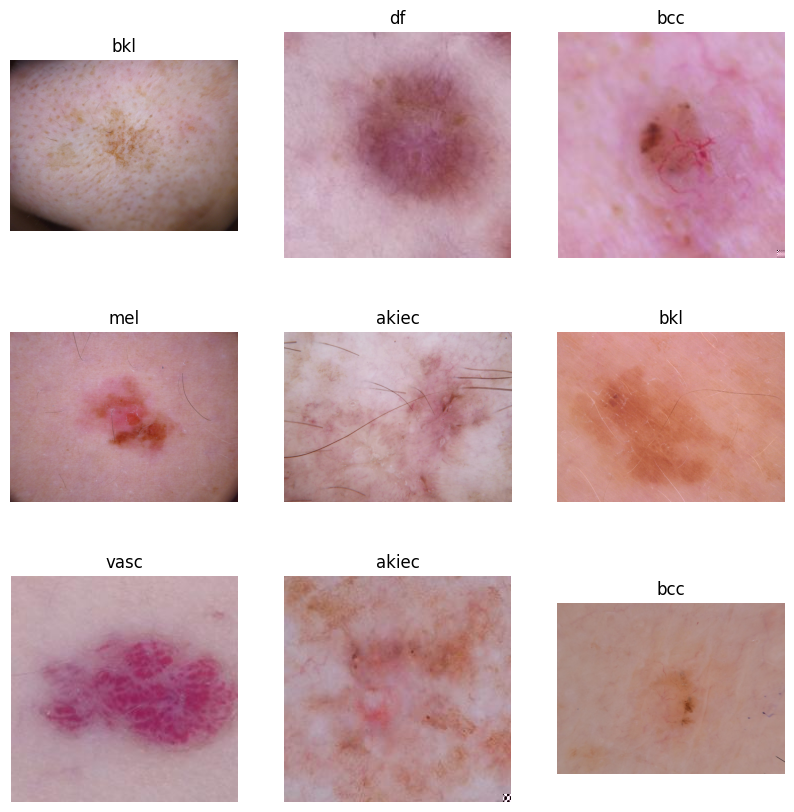

In [23]:
# Get a random sample of 9 images from the balanced_train_df
sample_df = balanced_train_df.sample(n=9, random_state=543)

# Create a list of image paths from the "image_path" column
image_paths = sample_df['image_path'].tolist()

# Create a list of image labels from the "dx" column
image_labels = sample_df['dx'].tolist()

# Load and plot the images without imagehelper
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.ravel()
for i, image_path in enumerate(image_paths):
    img = plt.imread(image_path)
    axes[i].imshow(img)
    axes[i].set_title(image_labels[i])
    axes[i].axis('off')




## Saving Test, Validation and Training data to csv

In [24]:
balanced_train_df.to_csv('../data/processed/train_from_Metadata_processed.csv', index=False)
balanced_validation_df.to_csv('../data/processed/validation_from_Metadata_processed.csv', index=False)
test_df.to_csv('../data/processed/test_from_Metadata_processed.csv', index=False)